# Merge Dask DataFrames

To do:
- Add some markdown
- use default coiled software env

## 1. Launch Coiled Cluster

In [69]:
import time

import coiled
import pandas as pd
import dask.dataframe as dd
import dask
import distributed
import matplotlib.pyplot as plt
import numpy as np

In [3]:
cluster = coiled.Cluster(
    name="dask-merge",
    n_workers=50,
    worker_memory='16Gib',
    backend_options={'spot':'True'},
    software='coiled-examples/numpy-zarr',
    shutdown_on_close=False,
)

/Users/rpelgrim/mambaforge/envs/numpy-zarr/lib/python3.9/site-packages/rich/live.py:221: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Found software environment build
Created fw rule: inbound [8786-8787] [0.0.0.0/0] []
Created FW rules: coiled-dask-rrpelgr71-98281-firewall
Created fw rule: cluster [0-65535] [None] [coiled-dask-rrpelgr71-98281-firewall -> coiled-dask-rrpelgr71-98281-firewall]
Created FW rules: coiled-dask-rrpelgr71-98281-cluster-firewall
Created fw rule: cluster [0-65535] [None] [coiled-dask-rrpelgr71-98281-cluster-firewall -> coiled-dask-rrpelgr71-98281-cluster-firewall]
Created scheduler VM: coiled-dask-rrpelgr71-98281-scheduler (type: t3a.medium, ip: ['3.227.232.233'])


In [4]:
from distributed import Client
client = Client(cluster)
client

/Users/rpelgrim/mambaforge/envs/numpy-zarr/lib/python3.9/site-packages/distributed/client.py:1128: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| msgpack | 1.0.3  | 1.0.2     | 1.0.2   |
+---------+--------+-----------+---------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tls://10.4.14.127:8786' processes=50 threads=400, memory=1.51 TiB>

## 2. Create Datasets

In [8]:
# create large dataset as parquet to S3
def submit_jobs():
    from distributed import get_client
    
    with get_client() as client:        
        large = dask.datasets.timeseries(start="1990-01-01", end="2020-01-01", freq="1s", partition_freq="1M")
        
        large.to_parquet(
            's3://coiled-datasets/dask-merge/large.parquet',
            engine="fastparquet"
        )

client.submit(submit_jobs).result()

In [17]:
# write small dataset as parquet to S3
def submit_jobs():
    from distributed import get_client
    
    with get_client() as client:        
        small = dask.datasets.timeseries(start="1990-01-31", end="2020-01-01", freq="1D", dtypes={"z": int}).compute()
        
        small.to_parquet(
            's3://coiled-datasets/dask-merge/small.parquet'
        )

client.submit(submit_jobs).result()

## 3. Merge Large Dask DataFrame to small pandas Dataframe

In [18]:
large = dd.read_parquet('s3://coiled-datasets/dask-merge/large.parquet')
small = pd.read_parquet('s3://coiled-datasets/dask-merge/small.parquet')

In [10]:
large.npartitions

359

In [11]:
large.head()

,id,name,x,y
timestamp,,,,
1990-01-31 00:00:00,964,Wendy,-0.588935,0.587432
1990-01-31 00:00:01,981,George,0.657202,-0.871205
1990-01-31 00:00:02,948,Edith,-0.904222,0.245642
1990-01-31 00:00:03,1052,Tim,-0.612337,0.072341
1990-01-31 00:00:04,998,George,-0.638432,-0.194386


In [22]:
small.head()

,z
timestamp,
1990-01-31,1001
1990-02-01,1038
1990-02-02,999
1990-02-03,1006
1990-02-04,1018


In [20]:
join = large.merge(
    small, 
    how="left", 
    on=["timestamp"]
)

In [21]:
join.head()

,id,name,x,y,z
timestamp,,,,,
1990-01-31 00:00:00,964,Wendy,-0.588935,0.587432,1001.0
1990-01-31 00:00:01,981,George,0.657202,-0.871205,NaN
1990-01-31 00:00:02,948,Edith,-0.904222,0.245642,NaN
1990-01-31 00:00:03,1052,Tim,-0.612337,0.072341,NaN
1990-01-31 00:00:04,998,George,-0.638432,-0.194386,NaN


In [15]:
join.loc["1990-02-01"].compute()

,id,name,x,y,z
timestamp,,,,,
1990-02-01 00:00:00,1029,Alice,0.951480,0.542765,1000.0
1990-02-01 00:00:01,1006,Laura,0.110207,-0.585922,NaN
1990-02-01 00:00:02,997,George,0.332245,-0.630354,NaN
1990-02-01 00:00:03,1023,Laura,0.702961,0.258879,NaN
1990-02-01 00:00:04,981,George,-0.134436,-0.890895,NaN
...,...,...,...,...,...
1990-02-01 23:59:55,993,Xavier,-0.732635,-0.348656,NaN
1990-02-01 23:59:56,1003,Hannah,0.801193,0.440596,NaN
1990-02-01 23:59:57,1064,Tim,0.580918,-0.652578,NaN


## 4. Benchmarking

Let's benchmark three ways of joining a Large Dask DataFrame to a small DataFrame that fits in memory:

1. Large Dask to Small pandas
2. Large Dask to Small Dask (1 partition)
3. Large Dask to Small Dask (10 partitions)

We'll also see if persisting the dataframes to cluster memory affects these benchmarks.

### 4.1. Benchmark with persisted dataframes

#### Join Large Dask to Small pandas

In [18]:
# benchmark join1

times_join1 = []

for i in range(0,5):
    client.restart()
    
    large = dd.read_parquet('s3://coiled-datasets/dask-merge/large.parquet').persist()
    small_df = pd.read_parquet('s3://coiled-datasets/dask-merge/small.parquet')
    small_ddf_1p = dd.from_pandas(small_df, npartitions=1).persist()
    small_ddf_10p = dd.from_pandas(small_df, npartitions=10).persist()
    
    distributed.wait([large, small_ddf_1p, small_ddf_10p])
    
    start = time.time()
    
    # merge dask dataframe with small pandas dataframe
    join1 = large.merge(
        small_df, 
        how="left", 
        on=["timestamp"]
    ).persist()

    distributed.wait(join1)
    
    elapsed_time = (time.time() - start)
    times_join1.append(elapsed_time)


In [19]:
#persisted
times_join1

[8.438324928283691,
 9.045840740203857,
 9.756731748580933,
 8.367408990859985,
 10.581943035125732]

In [55]:
df_join1 = pd.DataFrame(data=times_join1, columns=["time"])

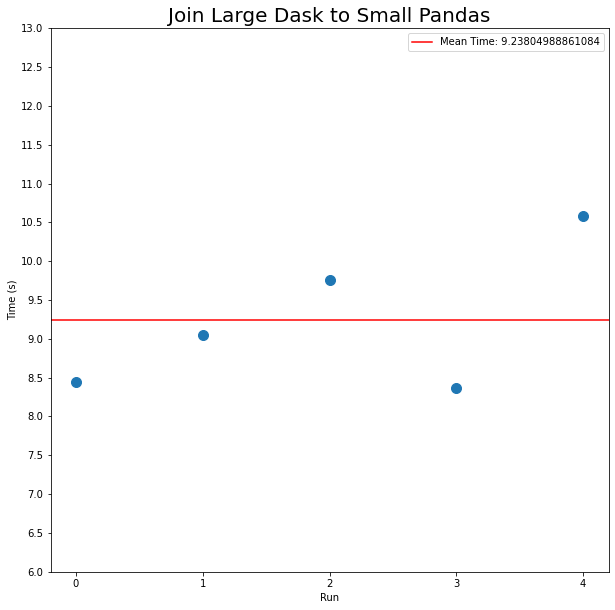

In [80]:
fig,ax = plt.subplots(figsize=[10,10])
plt.scatter(x=df_join1.index, y=df_join1.time, s=100)
plt.axhline(y=df_join1.time.mean(), c="red", label=f"Mean Time: {df_join1.time.mean()}")
plt.xticks(ticks=df_join1.index)
plt.yticks(ticks=np.linspace(6, 13, num=15))
plt.title("Join Large Dask to Small Pandas", fontsize=20)
plt.xlabel("Run")
plt.ylabel("Time (s)")
plt.legend();

#### Join Large Dask to Small Dask (1 partition)

In [20]:
# benchmark join2

times_join2 = []

for i in range(0,5):
    client.restart()
    
    large = dd.read_parquet('s3://coiled-datasets/dask-merge/large.parquet').persist()
    small_df = pd.read_parquet('s3://coiled-datasets/dask-merge/small.parquet')
    small_ddf_1p = dd.from_pandas(small_df, npartitions=1).persist()
    small_ddf_10p = dd.from_pandas(small_df, npartitions=10).persist()
    
    distributed.wait([large, small_ddf_1p, small_ddf_10p])
    
    start = time.time()
    
    # merge dask dataframe with small dask dataframe (1 partition)
    join2 = large.merge(
        small_ddf_1p, 
        how="left", 
        on=["timestamp"]
    ).persist()

    distributed.wait(join2)
    
    elapsed_time = (time.time() - start)
    times_join2.append(elapsed_time)


In [21]:
times_join2

[11.175489664077759,
 12.292428970336914,
 11.667414903640747,
 10.850434064865112,
 10.91507625579834]

In [82]:
df_join2 = pd.DataFrame(times_join2, columns=["time"])

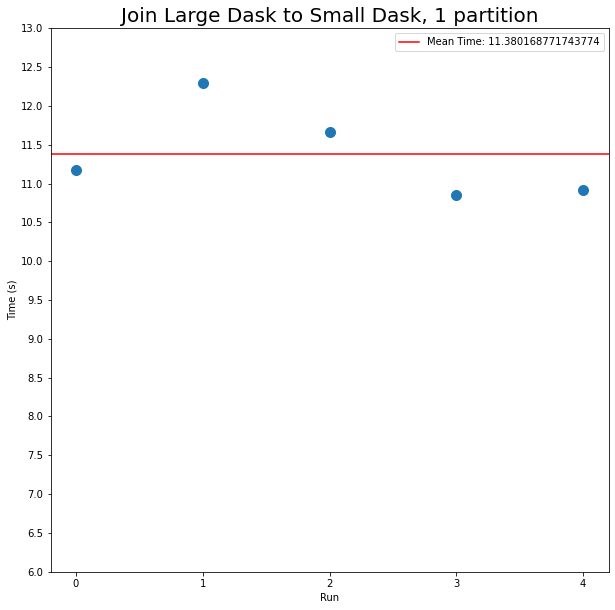

In [83]:
fig,ax = plt.subplots(figsize=[10,10])
plt.scatter(x=df_join2.index, y=df_join2.time, s=100)
plt.axhline(y=df_join2.time.mean(), c="red", label=f"Mean Time: {df_join2.time.mean()}")
plt.xticks(ticks=df_join2.index)
plt.yticks(ticks=np.linspace(6, 13, num=15))
plt.title("Join Large Dask to Small Dask, 1 partition", fontsize=20)
plt.xlabel("Run")
plt.ylabel("Time (s)")
plt.legend();

#### Join Large Dask to Small Dask (10 partitions)

In [22]:
# benchmark join3

times_join3 = []

for i in range(0,5):
    client.restart()
    
    large = dd.read_parquet('s3://coiled-datasets/dask-merge/large.parquet').persist()
    small_df = pd.read_parquet('s3://coiled-datasets/dask-merge/small.parquet')
    small_ddf_1p = dd.from_pandas(small_df, npartitions=1).persist()
    small_ddf_10p = dd.from_pandas(small_df, npartitions=10).persist()
    
    distributed.wait([large, small_ddf_1p, small_ddf_10p])
    
    start = time.time()
    
    # merge dask dataframe with small dask dataframe (10 partitions)
    join3 = large.merge(
        small_ddf_10p, 
        how="left", 
        on=["timestamp"]
    ).persist()

    distributed.wait(join3)
    
    elapsed_time = (time.time() - start)
    times_join3.append(elapsed_time)

In [23]:
times_join3

[12.233702182769775,
 10.868535995483398,
 12.452297925949097,
 10.761650085449219,
 11.031343221664429]

In [84]:
df_join3 = pd.DataFrame(times_join3, columns=["time"])

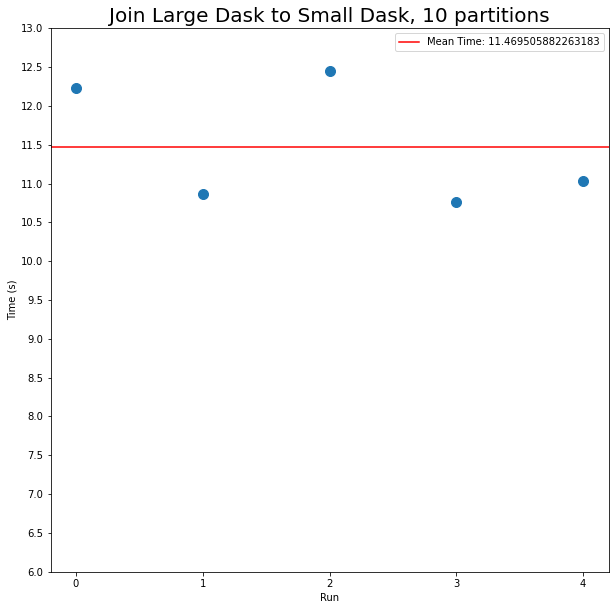

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [85]:
fig,ax = plt.subplots(figsize=[10,10])
plt.scatter(x=df_join3.index, y=df_join3.time, s=100)
plt.axhline(y=df_join3.time.mean(), c="red", label=f"Mean Time: {df_join3.time.mean()}")
plt.xticks(ticks=df_join3.index)
plt.yticks(ticks=np.linspace(6, 13, num=15))
plt.title("Join Large Dask to Small Dask, 10 partitions", fontsize=20)
plt.xlabel("Run")
plt.ylabel("Time (s)")
plt.legend();

### 4.2 Benchmark without persisting dataframes

#### Join Large Dask to Small Pandas

In [ ]:
times_join1_unper = []

for i in range(0,5):
    client.restart()
    
    large = dd.read_parquet('s3://coiled-datasets/dask-merge/large.parquet')
    small_df = pd.read_parquet('s3://coiled-datasets/dask-merge/small.parquet')
    small_ddf_1p = dd.from_pandas(small_df, npartitions=1)
    small_ddf_10p = dd.from_pandas(small_df, npartitions=10)
    
    distributed.wait([large, small_ddf_1p, small_ddf_10p])
    
    start = time.time()
    
    # merge dask dataframe with small pandas dataframe
    join1 = large.merge(
        small_df, 
        how="left", 
        on=["timestamp"]
    ).persist()

    distributed.wait(join1)
    
    elapsed_time = (time.time() - start)
    times_join1_unper.append(elapsed_time)


In [25]:
times_join1_unper

[41.1017370223999,
 32.89023995399475,
 37.884989976882935,
 38.64443063735962,
 38.75362300872803]

In [86]:
df_join1_unper = pd.DataFrame(times_join1_unper, columns=["time"])

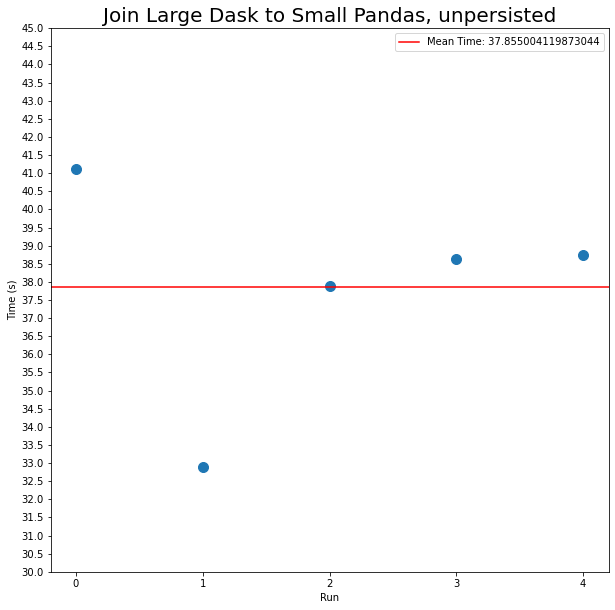

In [103]:
fig,ax = plt.subplots(figsize=[10,10])
plt.scatter(x=df_join1_unper.index, y=df_join1_unper.time, s=100)
plt.axhline(y=df_join1_unper.time.mean(), c="red", label=f"Mean Time: {df_join1_unper.time.mean()}")
plt.xticks(ticks=df_join1_unper.index)
plt.yticks(ticks=np.linspace(30, 45, num=31))
plt.title("Join Large Dask to Small Pandas, unpersisted", fontsize=20)
plt.xlabel("Run")
plt.ylabel("Time (s)")
plt.legend();

#### Join Large Dask to Small Dask (1 partition)

In [26]:
# benchmark join2

times_join2_unper = []

for i in range(0,5):
    client.restart()
    
    large = dd.read_parquet('s3://coiled-datasets/dask-merge/large.parquet')
    small_df = pd.read_parquet('s3://coiled-datasets/dask-merge/small.parquet')
    small_ddf_1p = dd.from_pandas(small_df, npartitions=1)
    small_ddf_10p = dd.from_pandas(small_df, npartitions=10)
    
    distributed.wait([large, small_ddf_1p, small_ddf_10p])
    
    start = time.time()
    
    # merge dask dataframe with small dask dataframe (1 partition)
    join2 = large.merge(
        small_ddf_1p, 
        how="left", 
        on=["timestamp"]
    ).persist()

    distributed.wait(join2)
    
    elapsed_time = (time.time() - start)
    times_join2_unper.append(elapsed_time)


In [27]:
times_join2_unper

[42.605679750442505,
 34.83511996269226,
 37.493804931640625,
 34.97790312767029,
 36.19682693481445]

In [104]:
df_join2_unper = pd.DataFrame(times_join2_unper, columns=["time"])

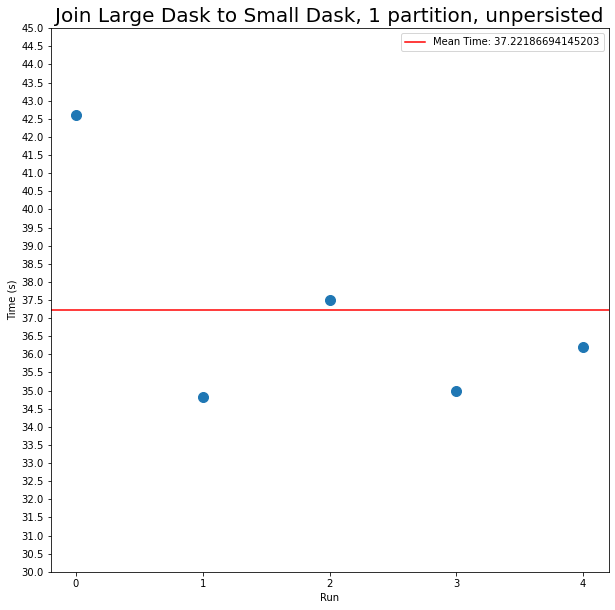

In [105]:
fig,ax = plt.subplots(figsize=[10,10])
plt.scatter(x=df_join2_unper.index, y=df_join2_unper.time, s=100)
plt.axhline(y=df_join2_unper.time.mean(), c="red", label=f"Mean Time: {df_join2_unper.time.mean()}")
plt.xticks(ticks=df_join2_unper.index)
plt.yticks(ticks=np.linspace(30, 45, num=31))
plt.title("Join Large Dask to Small Dask, 1 partition, unpersisted", fontsize=20)
plt.xlabel("Run")
plt.ylabel("Time (s)")
plt.legend();

#### Join Large Dask to Small Dask (10 partitions)

In [28]:
# benchmark join3

times_join3_unper = []

for i in range(0,5):
    client.restart()
    
    large = dd.read_parquet('s3://coiled-datasets/dask-merge/large.parquet')
    small_df = pd.read_parquet('s3://coiled-datasets/dask-merge/small.parquet')
    small_ddf_1p = dd.from_pandas(small_df, npartitions=1)
    small_ddf_10p = dd.from_pandas(small_df, npartitions=10)
    
    distributed.wait([large, small_ddf_1p, small_ddf_10p])
    
    start = time.time()
    
    # merge dask dataframe with small dask dataframe (10 partitions)
    join3 = large.merge(
        small_ddf_10p, 
        how="left", 
        on=["timestamp"]
    ).persist()

    distributed.wait(join3)
    
    elapsed_time = (time.time() - start)
    times_join3_unper.append(elapsed_time)


In [29]:
times_join3_unper

[32.203917026519775,
 34.18762707710266,
 34.33247208595276,
 32.51415205001831,
 33.393895864486694]

In [106]:
df_join3_unper = pd.DataFrame(times_join3_unper, columns=["time"])

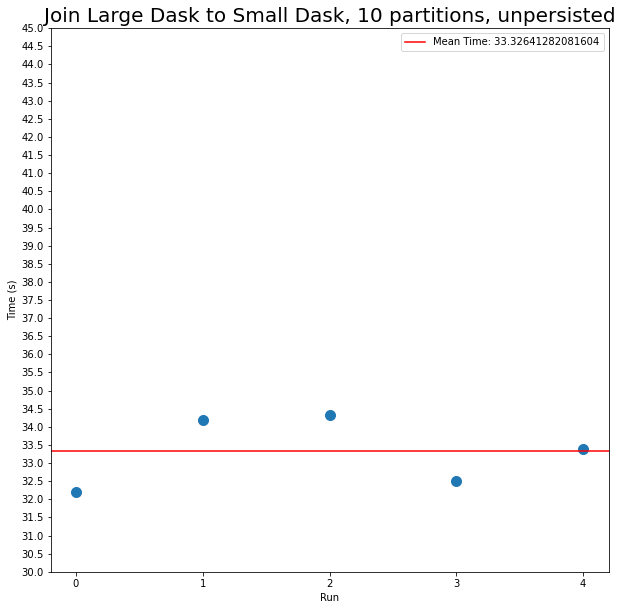

In [107]:
fig,ax = plt.subplots(figsize=[10,10])
plt.scatter(x=df_join3_unper.index, y=df_join3_unper.time, s=100)
plt.axhline(y=df_join3_unper.time.mean(), c="red", label=f"Mean Time: {df_join3_unper.time.mean()}")
plt.xticks(ticks=df_join3_unper.index)
plt.yticks(ticks=np.linspace(30, 45, num=31))
plt.title("Join Large Dask to Small Dask, 10 partitions, unpersisted", fontsize=20)
plt.xlabel("Run")
plt.ylabel("Time (s)")
plt.legend();

### Plot Means

In [111]:
df_means_persisted = pd.DataFrame(
    data=[df_join1.time.mean(), df_join2.time.mean(), df_join3.time.mean()], 
    columns=['mean_time_per_join']
)

In [113]:
df_means_persisted['join_type'] = ['dask_to_pandas', 'dask_to_dask_1partition', 'dask_to_dask_10partitions']

In [114]:
df_means_persisted

,mean_time_per_join,join_type
0,9.238050,dask_to_pandas
1,11.380169,dask_to_dask_1partition
2,11.469506,dask_to_dask_10partitions


In [120]:
df_means_unpersisted = pd.DataFrame(
    data=[df_join1_unper.time.mean(), df_join2_unper.time.mean(), df_join3_unper.time.mean()], 
    columns=['mean_time_per_join']
)

In [121]:
df_means_unpersisted['join_type'] = ['dask_to_pandas', 'dask_to_dask_1partition', 'dask_to_dask_10partitions']

In [122]:
df_means_unpersisted

,mean_time_per_join,join_type
0,37.855004,dask_to_pandas
1,37.221867,dask_to_dask_1partition
2,33.326413,dask_to_dask_10partitions


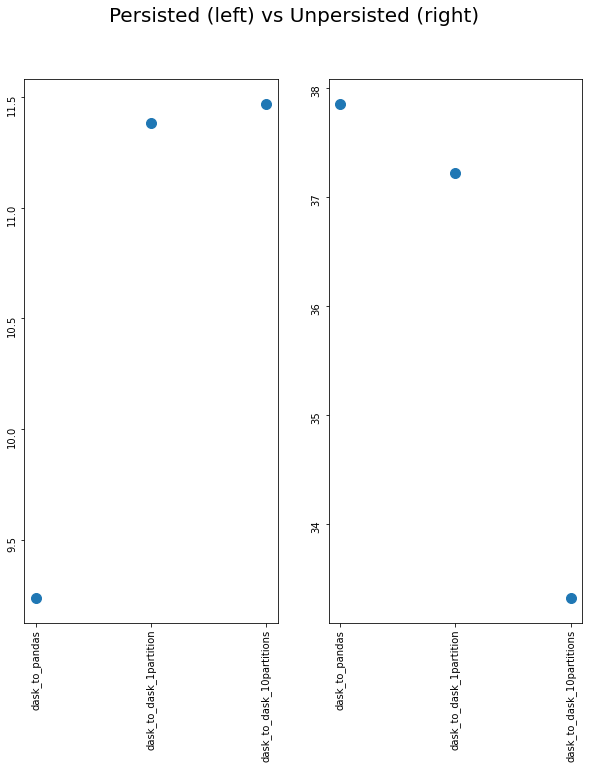

In [134]:
fig,axs = plt.subplots(1,2, figsize=(10,10))

axs[0].scatter(
    x=df_means_persisted.join_type, 
    y=df_means_persisted.mean_time_per_join,
    s=100,
)
axs[0].tick_params(labelrotation=90)

axs[1].scatter(
    x=df_means_unpersisted.join_type, 
    y=df_means_unpersisted.mean_time_per_join,
    s=100,
)
axs[1].tick_params(labelrotation=90)


fig.suptitle("Persisted (left) vs Unpersisted (right)", fontsize=20);

    

## 5. Merge two large Dask DataFrames

In [8]:
left = dask.datasets.timeseries(dtypes={"foo": int})
right_one = dask.datasets.timeseries(dtypes={"bar": int})
right_two = dask.datasets.timeseries(dtypes={"baz": int})

In [9]:
# timeseries returns a dataframe indexed by
# timestamp, we don't need to set_index.

# left.set_index("timestamp")

#left.to_parquet("left", overwrite=True)
#left = dd.read_parquet("left")

# If the dataframe can fit in RAM, you can also use persist

# left = left.persist()


result1 = left.merge(
    right_one, how="left", left_index=True, right_index=True)

In [13]:
result2 = result1.merge(
    right_two, how="left", left_index=True, right_index=True)

In [11]:
left.head()

,foo
timestamp,
2000-01-01 00:00:00,1032
2000-01-01 00:00:01,993
2000-01-01 00:00:02,993
2000-01-01 00:00:03,995
2000-01-01 00:00:04,995


In [10]:
result1.head()

,foo,bar
timestamp,,
2000-01-01 00:00:00,1032,1016
2000-01-01 00:00:01,993,949
2000-01-01 00:00:02,993,1004
2000-01-01 00:00:03,995,1023
2000-01-01 00:00:04,995,1042


In [14]:
result2.head()

,foo,bar,baz
timestamp,,,
2000-01-01 00:00:00,1032,1016,1014
2000-01-01 00:00:01,993,949,1010
2000-01-01 00:00:02,993,1004,984
2000-01-01 00:00:03,995,1023,1005
2000-01-01 00:00:04,995,1042,981


## Simple Example

In [35]:
import dask.dataframe as dd
import pandas as pd
df_large = pd.DataFrame(
    {
        "Name": ["Azza", "Brandon", "Cedric", "Devonte", "Eli", "Fabio"], 
        "Age": [29, 30, 21, 57, 32, 19]
    }
)
large = dd.from_pandas(df_large, npartitions=2)

In [36]:
small = pd.DataFrame(
    {
        "Name": ["Azza", "Cedric", "Fabio"], 
        "City": ["Beirut", "Dublin", "Rosario"]
    }
)

In [40]:
join = large.merge(small, how="left", on=["Name"])

In [41]:
join.compute()

,Name,Age,City
0,Azza,29,Beirut
1,Brandon,30,NaN
2,Cedric,21,Dublin
0,Devonte,57,NaN
1,Eli,32,NaN
2,Fabio,19,Rosario
